In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import sys
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as datetime

In [2]:
import torch
import torch.nn as nn
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import DataLoader, TensorDataset

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
#path = r'/home/ryuho/Documents/reddy/research/SMRAI/Data/REPPU/200/pbig5min.dat' #Ubuntu
path = r'/home/sachin/Documents/NIPR/Research/Data/REPPU/pbig5min.dat' #Server

#read the REPPU data
with open (path) as f:
    rectype = np.dtype(np.float32)
    reppu_data = np.fromfile(f, rectype) #size = 109,900,800

reppu_data = reppu_data.reshape(-1,30,80)
reppu_data.shape

(45792, 30, 80)

In [5]:
#Read MHD dates and expand-out the date ranges
mhd_data = pd.read_csv('mhd_dates.csv')
expanded_dt = pd.concat([pd.Series(pd.date_range(start, end)) 
    for start, end in zip(mhd_data['start'], mhd_data['end'])])

In [6]:
time_res = 5

if time_res == 1:
    time_step = 1440
else :
    time_step = 288

In [7]:
data_reshaped = reppu_data.reshape(len(expanded_dt), time_step, 30, 80) 

# Define coordinates
time = np.arange(time_step)
lat = np.linspace(53.1, 89.7, 30) #30 intervals between 53.1° to 89.7°
lon = np.linspace(1.6, 357.6, 80) #80 intervals between 1.6° to 357.6°

# Create 'dt' variable combining dates and five-minute intervals
dt = []
for day in expanded_dt:
    for t in time:
        dt.append(day + pd.Timedelta(minutes=t*time_res))
dt = np.array(dt) #convert from list to numpy array

# Create xarray Dataset
ds = xr.Dataset({'potential': (['dt', 'lat', 'lon'], data_reshaped.reshape(-1, 30, 80))},
coords={'dt': dt, 'lat': lat, 'lon': lon})

# Add potential and units
ds['potential'].attrs['units'] = 'kV'
ds['potential'] = ds['potential'] * 1e-3 # Convert to kV
ds

<xarray.Dataset> Size: 440MB
Dimensions:    (dt: 45792, lat: 30, lon: 80)
Coordinates:
  * dt         (dt) datetime64[ns] 366kB 2021-05-10 ... 2022-08-19T23:55:00
  * lat        (lat) float64 240B 53.1 54.36 55.62 56.89 ... 87.18 88.44 89.7
  * lon        (lon) float64 640B 1.6 6.106 10.61 15.12 ... 348.6 353.1 357.6
Data variables:
    potential  (dt, lat, lon) float32 440MB 0.6909 0.507 ... -22.67 -22.71

In [8]:
omni_df = pd.read_csv('omni_mhd_5min.csv')
#omni_df = pd.read_csv(omni_mhd_path+'omni_mhd_5min.csv')
omni_df.set_index('dt', inplace=True) #set the datetime as the index
omni_df = omni_df.ffill().bfill()
omni_df = omni_df.dropna() #drop any remaining NaNs
omni_df

omni_ds = xr.Dataset(omni_df)
omni_ds['dt'] = pd.to_datetime(omni_ds['dt']) #convert the index to datetime

#merge OMNI with REPPU data
reppu_omni_ds = ds.merge(omni_ds, join='outer')

#select date range
reppu_omni_ds = reppu_omni_ds.sortby('dt')
reppu_omni_ds

if time_res == 1:
    #interpolate the missing values in BY_GSE
    reppu_omni_ds['BY_GSE'] = reppu_omni_ds['BY_GSE'].interpolate_na(dim='dt')
    reppu_omni_ds['BZ_GSE'] = reppu_omni_ds['BZ_GSE'].interpolate_na(dim='dt')
    reppu_omni_ds['flow_speed'] = reppu_omni_ds['flow_speed'].interpolate_na(dim='dt')
    reppu_omni_ds['proton_density'] = reppu_omni_ds['proton_density'].interpolate_na(dim='dt')
    reppu_omni_ds['tilt_angle'] = reppu_omni_ds['tilt_angle'].interpolate_na(dim='dt')

    #drop nan values
    reppu_omni_ds = reppu_omni_ds.dropna('dt')
    reppu_omni_ds
else:
    pass

In [9]:
X_train_a = reppu_omni_ds.sel(dt=slice("2021-05-10","2022-06-30")) #123 days
X_train_b = reppu_omni_ds.sel(dt=slice("2022-08-15","2022-08-19")) #5 days
X_train_ds = xr.concat([X_train_a, X_train_b], dim='dt') #128 days ~ 80% of the data
X_test_ds = reppu_omni_ds.sel(dt=slice("2022-07-01","2022-07-15")) #15 days ~ 10% of the data
X_test_unscaled_ds = X_test_ds.copy() #keep a copy of the unscaled test data for later use
X_val_ds = reppu_omni_ds.sel(dt=slice("2022-07-16","2022-07-31")) #12 days ~ 10% of the data

In [10]:
# List of variables to be scaled (excluding 'potential')
variables_to_scale = [var for var in X_train_ds.data_vars if var != 'potential']

# Fit the scaler on training data
scaler = MinMaxScaler()

for var in variables_to_scale:
    # Reshape the variable to (-1, 1) to fit the scaler
    X_train_values = X_train_ds[var].values.reshape(-1,1)
    X_val_values = X_val_ds[var].values.reshape(-1, 1)
    X_test_values = X_test_ds[var].values.reshape(-1, 1)

    # Fit and transform on training data, then transform on test data
    scaled_train_values = scaler.fit_transform(X_train_values).reshape(X_train_ds[var].shape)
    scaled_val_values = scaler.transform(X_val_values).reshape(X_val_ds[var].shape)
    scaled_test_values = scaler.transform(X_test_values).reshape(X_test_ds[var].shape)
    
    # Update the xarray dataset with the scaled values
    X_train_ds[var] = (X_train_ds[var].dims, scaled_train_values)
    X_val_ds[var] = (X_val_ds[var].dims, scaled_val_values)
    X_test_ds[var] = (X_test_ds[var].dims, scaled_test_values)

In [11]:
def single_feat_ds(ds, lookback, var):
    ds_shifted = ds.copy()
    
    for i in range(1, lookback + 1):
        ds_shifted[f'BY_GSE(t-{i})'] = ds['BY_GSE'].shift(dt=i)
        ds_shifted[f'BZ_GSE(t-{i})'] = ds['BZ_GSE'].shift(dt=i)
        ds_shifted[f'flow_speed(t-{i})'] = ds['flow_speed'].shift(dt=i)
        ds_shifted[f'proton_density(t-{i})'] = ds['proton_density'].shift(dt=i)
        ds_shifted[f'tilt_angle(t-{i})'] = ds['tilt_angle'].shift(dt=i)

    ds_shifted = ds_shifted.dropna(dim='dt')
    
    return ds_shifted

# Example usage
lookback = 12
var = 'potential'

X_train_ds = single_feat_ds(X_train_ds, lookback, var)
X_val_ds = single_feat_ds(X_val_ds, lookback, var)
X_test_ds = single_feat_ds(X_test_ds, lookback, var)


In [12]:
X_train_ds

<xarray.Dataset> Size: 373MB
Dimensions:               (dt: 36852, lat: 30, lon: 80)
Coordinates:
  * dt                    (dt) datetime64[ns] 295kB 2021-05-10T01:00:00 ... 2...
  * lat                   (lat) float64 240B 53.1 54.36 55.62 ... 88.44 89.7
  * lon                   (lon) float64 640B 1.6 6.106 10.61 ... 353.1 357.6
Data variables: (12/66)
    potential             (dt, lat, lon) float32 354MB 2.362 1.814 ... -22.71
    BY_GSE                (dt) float64 295kB 0.6218 0.6 0.6025 ... 0.4641 0.4666
    BZ_GSE                (dt) float64 295kB 0.6589 0.6711 ... 0.3898 0.3927
    flow_speed            (dt) float64 295kB 0.1191 0.1209 ... 0.6715 0.6805
    proton_density        (dt) float64 295kB 0.1816 0.1745 ... 0.08256 0.07843
    tilt_angle            (dt) float64 295kB 0.689 0.6865 0.6841 ... 0.655 0.652
    ...                    ...
    tilt_angle(t-11)      (dt) float64 295kB 0.7187 0.7159 ... 0.6885 0.6854
    BY_GSE(t-12)          (dt) float64 295kB 0.606 0.5983 0.6037 ... 0.45 0.4536
    BZ_GSE(t-12)          (dt) float64 295kB 0.615 0.6214 ... 0.4349 0.4831
    flow_speed(t-12)      (dt) float64 295kB 0.1137 0.1137 ... 0.6643 0.6552
    proton_density(t-12)  (dt) float64 295kB 0.1902 0.1792 ... 0.09891 0.09841
    tilt_angle(t-12)      (dt) float64 295kB 0.7216 0.7187 ... 0.6916 0.6885

In [13]:
reset_dates = [
    #{"start": "2021/05/10 00:00:00", "end": "2021/05/14 23:59:59", "total_days": 5},
    {"start": "2021/05/31 00:00:00"},
    {"start": "2021/07/26 00:00:00"},
    {"start": "2021/09/09 00:00:00"},
    {"start": "2021/10/11 00:00:00"},
    {"start": "2021/11/01 00:00:00"},
    {"start": "2021/11/25 00:00:00"},
    {"start": "2021/12/01 00:00:00"},
    {"start": "2022/01/30 00:00:00"},
    {"start": "2022/03/11 00:00:00"},
    {"start": "2022/03/28 00:00:00"},
    {"start": "2022/06/10 00:00:00"},
    #{"start": "2022/07/01 00:00:00", "end": "2022/07/31 23:59:59", "total_days": 31}, #test data
    {"start": "2022/08/15 00:00:00"}
]

In [14]:
def remove_reset_date(ds, reset_dates, remove_range):

    ds = ds.copy()

    date = ds['dt'].values
    date = pd.to_datetime(date).to_pydatetime()

    reset_indices = [np.where(date == datetime.datetime.strptime(d["start"], "%Y/%m/%d %H:%M:%S"))[0][0] for d in reset_dates]

    reset_indices = np.array([list(range(i, min(i+remove_range, len(date)))) for i in reset_indices]).flatten()

    new_data = np.delete(ds['potential'].values, reset_indices, axis=0)
    new_dt = np.delete(date, reset_indices)

    new_ds = xr.Dataset({'potential': (['dt', 'lat', 'lon'], new_data)},
                        coords={'dt': new_dt, 'lat': ds['lat'].values, 'lon': ds['lon'].values})

    # Copy the attributes from the old Dataset
    new_ds['potential'].attrs = ds['potential'].attrs

    return new_ds

X_train_reset_ds = remove_reset_date(X_train_ds, reset_dates, lookback)
X_train_reset_ds

<xarray.Dataset> Size: 353MB
Dimensions:    (dt: 36708, lat: 30, lon: 80)
Coordinates:
  * dt         (dt) datetime64[ns] 294kB 2021-05-10T01:00:00 ... 2022-08-19T2...
  * lat        (lat) float64 240B 53.1 54.36 55.62 56.89 ... 87.18 88.44 89.7
  * lon        (lon) float64 640B 1.6 6.106 10.61 15.12 ... 348.6 353.1 357.6
Data variables:
    potential  (dt, lat, lon) float32 352MB 2.362 1.814 1.239 ... -22.67 -22.71

In [15]:
X_train = X_train_ds.drop_vars('potential').to_array().values.T
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1] , 1)
y_train = X_train_ds['potential'].values
y_train = y_train.reshape(-1, 30*80)

X_val = X_val_ds.drop_vars('potential').to_array().values.T
X_val = X_val.reshape(X_val.shape[0], X_val.shape[1] , 1)
y_val = X_val_ds['potential'].values
y_val = y_val.reshape(-1, 30*80)

X_test = X_test_ds.drop_vars('potential').to_array().values.T
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1] , 1)
y_test = X_test_ds['potential'].values
y_test = y_test.reshape(-1, 30*80)

X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

((36852, 65, 1),
 (36852, 2400),
 (4596, 65, 1),
 (4596, 2400),
 (4308, 65, 1),
 (4308, 2400))

In [26]:
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).to(device)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32).to(device)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32).to(device)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).to(device)

X_train_tensor.shape, y_train_tensor.shape, X_val_tensor.shape, y_val_tensor.shape, X_test_tensor.shape, y_test_tensor.shape

(torch.Size([36852, 65, 1]),
 torch.Size([36852, 2400]),
 torch.Size([4596, 65, 1]),
 torch.Size([4596, 2400]),
 torch.Size([4308, 65, 1]),
 torch.Size([4308, 2400]))

In [27]:
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
batch_size = 8 #bigger batch size = faster training

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [18]:
for _, batch in enumerate(train_loader):
    x_batch, y_batch = batch[0].to(device), batch[1].to(device)
    print(x_batch.shape, y_batch.shape)
    break
#batch.shape, y_batch.shape

torch.Size([8, 65, 1]) torch.Size([8, 2400])


In [28]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_stacked_layers):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_stacked_layers = num_stacked_layers

        self.lstm = nn.LSTM(input_size, hidden_size, num_stacked_layers, 
                            batch_first=True)
        
        self.fc = nn.Linear(hidden_size, 2400)

    def forward(self, x):
        batch_size = x.size(0)
        h0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)
        c0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)
        
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out
    
    def reset_states(self):
        # Reset the internal states of the LSTM layer
        self.lstm.reset_parameters()

# Instantiate the model with the correct input size
model = LSTM(X_train.shape[1], 64, 2)
model.to(device)
model


LSTM(
  (lstm): LSTM(65, 64, num_layers=2, batch_first=True)
  (fc): Linear(in_features=64, out_features=2400, bias=True)
)

In [35]:
# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

best_val_loss = float('inf')
patience = np.inf
wait = 0

train_losses = []
val_losses = []
num_epochs = 2

start_time = datetime.datetime.now()
for epoch in range(num_epochs):

    # ------------------------------
    # Training
    # ------------------------------
    model.train()
    running_loss = 0.0
    for batch_X, batch_y in train_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        batch_X = batch_X.permute(0, 2, 1)  #permute dimensions

        #forward
        output = model(batch_X) #forward pass
        loss = criterion(output, batch_y) #calculate loss
        running_loss += loss.item() #accumulate loss
        
        #backward
        optimizer.zero_grad() #zero gradients
        loss.backward() #backpropagation
        optimizer.step() #update weights

    #calculate average loss
    avg_train_loss = running_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    
    # ------------------------------
    # Validation
    # ------------------------------
    model.eval()
    val_loss = 0.0
    
    with torch.no_grad(): #val has no gradients because we are not training
        for batch_X, batch_y in val_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            batch_X = batch_X.permute(0, 2, 1)            
            output = model(batch_X) 
            loss = criterion(output, batch_y)
            val_loss += loss.item()
    
    avg_val_loss = val_loss / len(val_loader)
    val_losses.append(avg_val_loss)
    
    print(f'Epoch: {epoch + 1}, Train Loss: {np.sqrt(avg_train_loss):.3f} [kV], Val Loss: {np.sqrt(avg_val_loss):.3f} [kV]')
    
    # Early stopping
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        wait = 0
        #torch.save(model.state_dict(), 'best_model.pth')
    else:
        wait += 1
        if wait >= patience:
            print(f"Validation loss did not improve for {patience} epochs. Stopping training.")
            end_time = dt.datetime.now()
            diff = end_time - start_time
            print(f'Training Time: {diff}')
            break

#best_model = model
#best_model.load_state_dict(torch.load('best_model.pth'))

Epoch: 1, Train Loss: 8.945 [kV], Val Loss: 12.278 [kV]
Epoch: 2, Train Loss: 8.838 [kV], Val Loss: 12.362 [kV]


(4.0, 15.0)

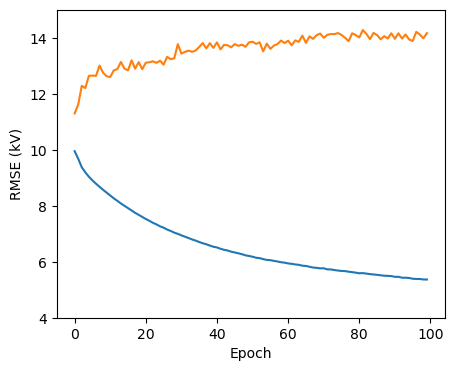

In [21]:
# Plot the RMSE values
plt.figure(figsize=(5, 4))
plt.plot(np.array(np.sqrt(train_losses)), label='RMSE')
plt.plot(np.array(np.sqrt(val_losses)), label='Val RMSE')
plt.xlabel('Epoch')
plt.ylabel('RMSE (kV)')
plt.ylim(4, 15)

In [23]:
#test
model.eval()

test_loss = 0.0
predictions = []

with torch.no_grad():
    for batch_index, batch in enumerate(test_loader):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)
        x_batch = x_batch.permute(0, 2, 1)  # permute dimensions

        output = model(x_batch)
        loss = criterion(output, y_batch)
        test_loss += loss.item()
        predictions.append(output)

avg_test_loss = test_loss / len(test_loader)
print(f'Test Loss: {np.sqrt(avg_test_loss):.3f} [kV]')

Test Loss: 10.852 [kV]
